---
title: "Selecting threshold"
execute:
  echo: true
  enabled: false
  output: true
  warning: false
format:
    html:
        code-fold: false
---

In [2]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "ray"
import modin.pandas as pd
import numpy as np

import ray
from detect_common import *

ray.init(address='auto', ignore_reinit_error=True)
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

2023-03-14 10:17:36,410	INFO worker.py:1352 -- Connecting to existing Ray cluster at address: 192.168.1.93:6379...
2023-03-14 10:17:36,492	INFO worker.py:1529 -- Connected to Ray cluster. View the dashboard at 192.168.1.93:8265 


## Predict DoH traffic

In [2]:
#| echo: false
#| output: false
p1version = "v5"
p2version = "v6"
p3version = "v4"

threshold = 0.18

In [3]:
import dateutil.parser

android = pd.read_feather("/jupyter/warehouse/flubot20230310/v4.ft")

In [4]:
df = pd.read_feather(f"/jupyter/warehouse/flubot20230310/{p3version}.ft")
# non_doh = df[df["ipaddr SRC_IP"] == "192.168.2.249"]
# some_doh = df[df["ipaddr SRC_IP"] == "192.168.2.149"]
# mal_doh = df[df["ipaddr SRC_IP"] == "192.168.2.217"]

In [5]:
# df_benign = pd.read_feather(f"/jupyter/warehouse/flubot20230310/v4_benign.ft")
# some_doh_add = df_benign[df_benign["ipaddr SRC_IP"] == "192.168.2.149"]

In [6]:
path_doh_ips = "/jupyter/kladovka/data/Jerabek2022Collection/doh_resolver_ip.csv"

cp = CacheableProcessing(100, 100, get_doh_ips(path_doh_ips))
df_p = cp.process(df, f"cached/p3.{p3version}.cp.ft")
# non_doh_p = cp.process(non_doh, f"cached/non_doh.p3.{p3version}.saved")
# some_doh_p = cp.process(some_doh, f"cached/some_doh.p3.{p3version}.saved")
# some_doh_add_p = cp.process(some_doh_add, f"cached/some_doh_add.p3.{p3version}.saved")
# mal_doh_p = cp.process(mal_doh, f"cached/mal_doh.p3.{p3version}.saved")

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
Reason: `lines` argument not supported


In [7]:
from joblib import dump, load

models = {
    1: {"params": ["RF", True, [2, 4, 0, 0]]},
    2: {"params": ["RF", False, [2, 4, 0, 0]]},
}

for i, data in models.items():
    model, normed, skips_and_weights = data["params"]
    name = (
        ('normed-' if normed else 'unnormed-') + 
        '-'.join(str(p) for p in skips_and_weights)
    )
    clf = load(f'models/{model}-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib')
    data["clf"] = clf


In [8]:
# cache preprocessing...
for i, data in models.items():
    model, normed, skips_and_weights = data["params"]
    name = (
        ('normed-' if normed else 'unnormed-') + 
        '-'.join(str(p) for p in skips_and_weights)
    )

    pp = PreProcessing(normed, *skips_and_weights)

    df_pp = pp.process(df_p, f"cached/p3.{p3version}.pp.{model}-{name}.saved")


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported


In [9]:
def predict(pp, clf, threshold, df_pp, df_orig):
    """
    pp: PreProcessing object
    clf: classifier
    threshold: >=threshold for positive (DoH) class
    df_pp: preprocessed dataframe
    df_orig: unprocessed dataframe
    """
    df_pp2 = df_pp.copy()

    df_pp2["IsDoHPredicted"] = (clf.predict_proba(df_pp2[pp.feature_fields])[:,1] >= threshold).astype(bool)

    df_orig2 = df_orig.copy()
    # fill predicted to the original dataframe
    df_orig2["IsDoHPredicted"] = df_pp2["IsDoHPredicted"]
    # non-443 rows will be NaN, replace with False
    df_orig2["IsDoHPredicted"] = df_orig2["IsDoHPredicted"].fillna(False)

    return df_orig2


In [10]:
for i, data in models.items():
    model, normed, skips_and_weights = data["params"]
    name = (
        ('normed-' if normed else 'unnormed-') + 
        '-'.join(str(p) for p in skips_and_weights)
    )

    pp = PreProcessing(normed, *skips_and_weights)

    df_pp = cp.process(df_p, f"cached/p3.{p3version}.pp.{model}-{name}.saved")

    df_pred = predict(pp, data["clf"], threshold, df_pp, df)
    data["df_pred"] = df_pred  # dataframe with predicted values


Reason: `lines` argument not supported
Reason: `lines` argument not supported


In [15]:
def calc(df_n, doh_field="IsDoHPredicted"):
    def rate(df_h):
        dns_packets = df_h[df_h[doh_field] == True]["uint32 PACKETS"].sum()  # outgoing packets
        non_dns_ips = set(df_h[df_h[doh_field] == False]["ipaddr SRC_IP"].unique()).union(
            set(df_h[df_h[doh_field] == False]["ipaddr DST_IP"].unique()))
        rate = float(dns_packets) / (1.0 + len(non_dns_ips))
        return {"dns_packets": dns_packets, "non_dns": len(non_dns_ips), "rate": rate, "rate_log": np.log(rate)}

    return pd.DataFrame({ ip: rate(grp) for ip, grp in df_n.groupby(["ipaddr SRC_IP"]) }).T.reset_index()


## Calculate ratio on the whole dataset

In [12]:
for i, data in models.items():
    print(data["params"])
    df_pred = data["df_pred"]
    local_df = df_pred[df_pred["ipaddr SRC_IP"].str.startswith("192.168")]
    display(calc(local_df))


['RF', True, [2, 4, 0, 0]]


,index,dns_packets,non_dns,rate,rate_log
0,192.168.1.1,0.0,2.0,0.000000,-inf
1,192.168.2.149,40831.0,837.0,48.724344,3.886179
2,192.168.2.217,1146337.0,23.0,47764.041667,10.774028
3,192.168.2.249,33540.0,799.0,41.925000,3.735882
4,192.168.2.42,0.0,3.0,0.000000,-inf


['RF', False, [2, 4, 0, 0]]


,index,dns_packets,non_dns,rate,rate_log
0,192.168.1.1,0.0,2.0,0.000000,-inf
1,192.168.2.149,22292.0,1021.0,21.812133,3.082466
2,192.168.2.217,217782.0,24.0,8711.280000,9.072374
3,192.168.2.249,12525.0,973.0,12.859343,2.554071
4,192.168.2.42,0.0,3.0,0.000000,-inf


## Split into time windows

In [13]:
min_ts = df["time TIME_FIRST"].apply(dateutil.parser.parse).min()

In [14]:
local_ips = local_df["ipaddr SRC_IP"].unique().tolist()
local_ips

['192.168.2.217',
 '192.168.2.149',
 '192.168.1.1',
 '192.168.2.249',
 '192.168.2.42']

In [15]:
f = '2min'

for i, data in models.items():
    print(data["params"])
    df_pred = data["df_pred"]
    local_df = df_pred[df_pred["ipaddr SRC_IP"].str.startswith("192.168")].copy()
    local_df["time TIME_FIRST"] = local_df["time TIME_FIRST"].apply(dateutil.parser.parse)
    # display(calc(local_df))
    
    calc_ips = {}
    # for host in local_ips:
        # a1_t = local_df[local_df["ipaddr SRC_IP"] == host].set_index(["time TIME_FIRST"])
    a1_t = local_df.set_index(["time TIME_FIRST"])

    # a1_t53 = a1_t[a1_t["uint16 DST_PORT"] == dst_port][["uint32 PACKETS", "uint32 PACKETS_REV"]]
    # a1_t53["PACKETS"] = a1_t53["uint32 PACKETS"] + a1_t53["uint32 PACKETS_REV"]
    df_resample = a1_t.groupby(pd.Grouper(freq=f, origin=min_ts)).first()
    times = df_resample.index.tolist()
    ranges = list(zip(times, times[1:]))

    df_calcs = []
    for ran in ranges:
        df_ran = a1_t[(a1_t.index > ran[0]) & (a1_t.index < ran[1])]
        df_calc = calc(df_ran)
        df_calc["ts"] = ran[0]
        df_calcs.append(df_calc)

    data["df_calc"] = pd.concat(df_calcs).reset_index(drop=True)

['RF', True, [2, 4, 0, 0]]


['RF', False, [2, 4, 0, 0]]


['RF', True, [2, 4, 0, 0]]


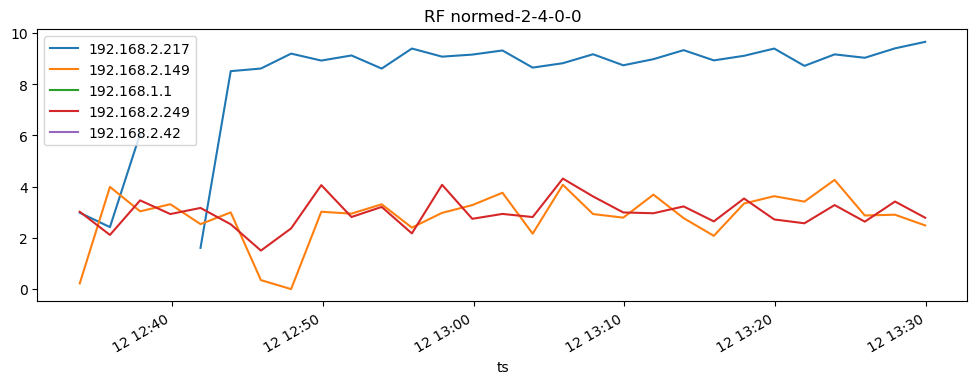

['RF', False, [2, 4, 0, 0]]


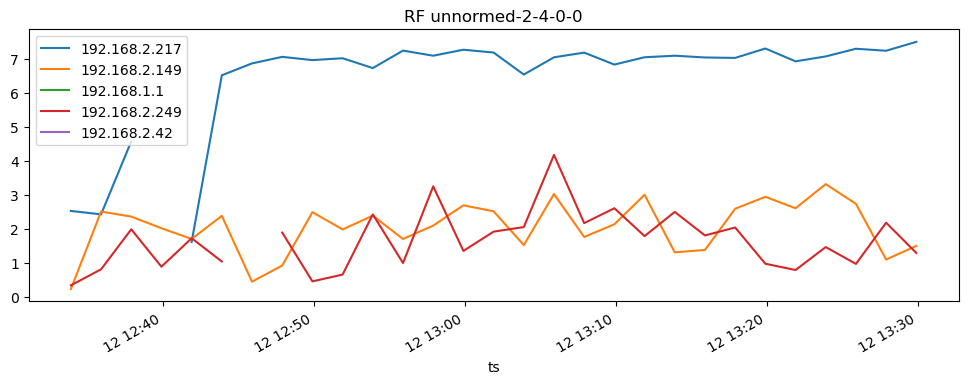

2023-03-13 22:40:04,094	WARNING worker.py:1851 -- WARNING: 58 PYTHON worker processes have been started on node: abe45bd300753fb96a4d132ee9b3394d97ebd9db8cb673e024af2818 with address: 192.168.1.93. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).
2023-03-13 22:41:39,974	WARNING worker.py:1851 -- WARNING: 66 PYTHON worker processes have been started on node: abe45bd300753fb96a4d132ee9b3394d97ebd9db8cb673e024af2818 with address: 192.168.1.93. This could be a result of using a large number of actors, or due to tasks blocked in ray.get() calls (see https://github.com/ray-project/ray/issues/3644 for some discussion of workarounds).


In [18]:
import matplotlib.pyplot as plt

for i, data in models.items():
    model, normed, skips_and_weights = data["params"]
    name = (
        ('normed-' if normed else 'unnormed-') + 
        '-'.join(str(p) for p in skips_and_weights)
    )

    fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
    print(data["params"])
    df_calcs = data["df_calc"]
    for host in local_ips:
        df_calc_host = df_calcs[df_calcs["index"] == host].set_index("ts")
        df_calc_host["rate_log"].plot(label=f'{host}', ax=axs)

    plt.title(f"{model} {name}")
    plt.legend()
    plt.show()

In [1]:
rw_2 = pd.read_csv(
    "/jupyter/warehouse/Jerabek2022Collection-unirec/unirec-csv-p100/"
    "unirec/DoH-Real-World/data/captured/pcap/"
    "DoH-17072021-48h.pcapng.trapcap.csv"
)


NameError: name 'pd' is not defined

In [ ]:
path_doh_ips = "/jupyter/kladovka/data/Jerabek2022Collection/doh_resolver_ip.csv"

cp = CacheableProcessing(100, 100, get_doh_ips(path_doh_ips))
rw_2_p = cp.process(rw_1, f"cached/rw-2.p3.{p3version}.saved")
rw_2_p["time TIME_FIRST"] = rw_1_p["time TIME_FIRST"].apply(dateutil.parser.parse)

In [25]:
rw_1_p[rw_1_p["IsDoH"] == True]

,ipaddr DST_IP,ipaddr SRC_IP,uint64 BYTES,uint64 BYTES_REV,uint64 LINK_BIT_FIELD,time TIME_FIRST,time TIME_LAST,macaddr DST_MAC,macaddr SRC_MAC,uint32 PACKETS,uint32 PACKETS_REV,uint16 DST_PORT,uint16 SRC_PORT,uint16 TLS_VERSION,uint8 DIR_BIT_FIELD,uint8 PROTOCOL,uint8 TCP_FLAGS,uint8 TCP_FLAGS_REV,int8* PPI_PKT_DIRECTIONS,uint8* PPI_PKT_FLAGS,string TLS_ALPN,bytes TLS_JA3,string TLS_SNI,uint16* PPI_PKT_LENGTHS,uint32* D_PHISTS_IPT,uint32* D_PHISTS_SIZES,uint32* S_PHISTS_IPT,uint32* S_PHISTS_SIZES,time* PPI_PKT_TIMES,uint16* PPI_PKT_LENGTHS_1,uint16* PPI_PKT_LENGTHS_-1,PPI_PKT_INTERVALS,PPI_PKT_INTERVALS_1,PPI_PKT_INTERVALS-1,IsDoH


In [13]:
rw_1_p_min_ts = rw_1_p["time TIME_FIRST"].min()

In [18]:
f = '2min'

a1_t = rw_1_p.set_index(["time TIME_FIRST"])

# a1_t53 = a1_t[a1_t["uint16 DST_PORT"] == dst_port][["uint32 PACKETS", "uint32 PACKETS_REV"]]
# a1_t53["PACKETS"] = a1_t53["uint32 PACKETS"] + a1_t53["uint32 PACKETS_REV"]
df_resample = a1_t.groupby(pd.Grouper(freq=f, origin=rw_1_p_min_ts)).first()
times = df_resample.index.tolist()
ranges = list(zip(times, times[1:]))

df_calcs = []
for ran in ranges[:10]:
    print(ran)
    df_ran = a1_t[(a1_t.index > ran[0]) & (a1_t.index < ran[1])]
    df_calc = calc(df_ran, "IsDoH")
    df_calc["ts"] = ran[0]
    df_calcs.append(df_calc)

# data["df_calc"] = pd.concat(df_calcs).reset_index(drop=True)

(Timestamp('2021-10-04 10:18:57.444786', freq='2T'), Timestamp('2021-10-04 10:20:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:20:57.444786', freq='2T'), Timestamp('2021-10-04 10:22:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:22:57.444786', freq='2T'), Timestamp('2021-10-04 10:24:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:24:57.444786', freq='2T'), Timestamp('2021-10-04 10:26:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:26:57.444786', freq='2T'), Timestamp('2021-10-04 10:28:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:28:57.444786', freq='2T'), Timestamp('2021-10-04 10:30:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:30:57.444786', freq='2T'), Timestamp('2021-10-04 10:32:57.444786', freq='2T'))
(Timestamp('2021-10-04 10:32:57.444786', freq='2T'), Timestamp('2021-10-04 10:34:57.444786', freq='2T'))


In [23]:
df_ran

,ipaddr DST_IP,ipaddr SRC_IP,uint64 BYTES,uint64 BYTES_REV,uint64 LINK_BIT_FIELD,time TIME_LAST,macaddr DST_MAC,macaddr SRC_MAC,uint32 PACKETS,uint32 PACKETS_REV,uint16 DST_PORT,uint16 SRC_PORT,uint16 TLS_VERSION,uint8 DIR_BIT_FIELD,uint8 PROTOCOL,uint8 TCP_FLAGS,uint8 TCP_FLAGS_REV,int8* PPI_PKT_DIRECTIONS,uint8* PPI_PKT_FLAGS,string TLS_ALPN,bytes TLS_JA3,string TLS_SNI,uint16* PPI_PKT_LENGTHS,uint32* D_PHISTS_IPT,uint32* D_PHISTS_SIZES,uint32* S_PHISTS_IPT,uint32* S_PHISTS_SIZES,time* PPI_PKT_TIMES,uint16* PPI_PKT_LENGTHS_1,uint16* PPI_PKT_LENGTHS_-1,PPI_PKT_INTERVALS,PPI_PKT_INTERVALS_1,PPI_PKT_INTERVALS-1,IsDoH
time TIME_FIRST,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-10-04 10:32:57.533947,58.118.214.56,161.113.1.74,2010,4037,1,2021-10-04T10:32:57.582531,42:9c:6f:05:32:04,03:b8:2d:ba:cb:5a,11,15,443,59879,0,0,6,26,26,"[1, -1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1...",[24|24|24|24|24|24|24|24|24|16|24|16|24|24],NaN,NaN,NaN,"[517, 212, 64, 92, 651, 207, 179, 80, 57, 350,...",[7|0|0|0|0|0|0|0],[0|0|1|2|2|1|0|2],[5|0|0|0|0|0|0|0],[0|1|0|2|1|0|2|0],[2021-10-04T10:32:57.566282|2021-10-04T10:32:5...,"[517, 64, 92, 651, 207, 31]","[212, 179, 80, 57, 350, 1111, 94, 1346]","[1.26, 5.058, 0.155, 0.131, 0.0, 0.481, 0.0710...","[1.26, 0.155, 0.131, 0.0, 0.481]","[5.058, 0.07100000000000001, 0.799, 0.212, 0.0...",False
2021-10-04 10:32:57.606320,209.251.64.226,30.25.78.1,52,52,1,2021-10-04T10:32:57.611590,a2:71:b3:29:89:22,1e:03:a1:2e:1d:f1,1,1,443,44980,0,0,6,16,16,[],[],NaN,NaN,NaN,[],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[],[],[],[],[],[],False
2021-10-04 10:32:57.911037,228.59.93.155,246.1.179.48,41,52,1,2021-10-04T10:32:57.916324,a2:71:b3:29:89:22,1e:03:a1:2e:1d:f1,1,1,443,61043,0,0,6,16,16,[1],[16],NaN,NaN,NaN,[1],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[1|0|0|0|0|0|0|0],[2021-10-04T10:32:57.911037],[1],[],[],[],[],False
2021-10-04 10:32:57.743516,84.113.70.202,15.142.52.163,52,52,1,2021-10-04T10:32:57.748781,a2:71:b3:29:89:22,1e:03:a1:2e:1d:f1,1,1,443,36512,0,0,6,16,16,[],[],NaN,NaN,NaN,[],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[],[],[],[],[],[],False
2021-10-04 10:32:57.884957,228.59.93.155,246.1.179.48,41,52,1,2021-10-04T10:32:57.890233,a2:71:b3:29:89:22,1e:03:a1:2e:1d:f1,1,1,443,54682,0,0,6,16,16,[1],[16],NaN,NaN,NaN,[1],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[0|0|0|0|0|0|0|0],[1|0|0|0|0|0|0|0],[2021-10-04T10:32:57.884957],[1],[],[],[],[],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-04 10:33:59.013424,66.254.222.201,183.45.147.63,12630,84722,1,2021-10-04T10:36:54.321942,a2:71:b3:29:89:22,1e:03:a1:2e:1d:f1,309,335,443,61160,0,0,6,24,24,"[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1...",[24|24|24|24|24|24|24|24|24|24|24|24|24|24|24|...,NaN,NaN,NaN,"[125, 62, 54, 47, 101, 272, 94, 292, 172, 83, ...",[6|11|21|48|67|60|60|56],[0|0|32|117|90|63|25|3],[0|0|0|0|0|0|0|4],[0|0|5|0|0|0|0|0],[2021-10-04T10:33:59.193054|2021-10-04T10:33:5...,"[54, 54]","[125, 62, 47, 101, 272, 94, 292, 172, 83, 193,...","[736.328, 131.133, 113.645, 1455.074, 172.988,...","[113.645, 115.392]","[736.328, 131.133, 1455.074, 172.988, 652.169,...",False
2021-10-04 10:33:57.592477,253.17.88.220,226.239.36.48,190320,2096644,1,2021-10-04T10:36:53.678502,7a:4c:0b:75:a6:95,03:b8:2d:ba:cb:5a,444,1486,443,61650,0,0,6,24,24,"[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1...",[24|16|16|16|16|16|24|16|16|16|16|16|16|24|24|...,NaN,NaN,NaN,"[1438, 1460, 1460, 1460, 1460, 1460, 896, 1460...",[1351|0|0|0|0|0|2|117],[0|5|5|4|2|17|108|1330],[0|0|0|0|0|0|2|117],[0|0|0|0|0|0|0|120],[2021-10-04T10:33:57.592477|2021-10-04T10:33:5...,"[1438, 1438, 1438, 1438, 1438, 1438, 1438, 1438]","[1460, 1460, 1460, 1460, 1460, 896, 1460, 1460...","[106.469, 0.011, 0.009000000000000001, 0.011, ...","[106.469, 3.063, 3.383, 3.43, 3.169, 2.971, 3....","[0.011, 0.009000000000000001, 0.011, 0.01, 0.0...",False
2021

In [20]:
r = pd.concat(df_calcs).reset_index(drop=True)

In [22]:
r[r["dns_packets"] > 0]

,index,dns_packets,non_dns,rate,rate_log,ts


In [ ]:
import matplotlib.pyplot as plt

for i, data in models.items():
    model, normed, skips_and_weights = data["params"]
    name = (
        ('normed-' if normed else 'unnormed-') + 
        '-'.join(str(p) for p in skips_and_weights)
    )

    fig, axs = plt.subplots(ncols=1, figsize=(12, 4))
    print(data["params"])
    df_calcs = data["df_calc"]
    for host in local_ips:
        df_calc_host = df_calcs[df_calcs["index"] == host].set_index("ts")
        df_calc_host["rate_log"].plot(label=f'{host}', ax=axs)

    plt.title(f"{model} {name}")
    plt.legend()
    plt.show()

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)